In [337]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [338]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [339]:
import socket
myHostName = socket.gethostname()
print(myHostName)

Tarins-MacBook.local


In [340]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 500

# learning rate
lr = 0.001

prediction_type = 'classification'

parameter = 'omega_0(rad|s)'

### Dataloader

In [341]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        self.parameters = y

        x = np.transpose(x)
        self.data = x

        ### signal manipulation section ###
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            # cut signal down to last 256 samples
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

        self.data = temp_data
        ### end signal manipulation section ###
        print(self.data.shape)
        print(self.parameters.shape)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        return signal, parameter

In [342]:
x = pd.read_csv("../data/richers_1764.csv")
y = pd.read_csv("../data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
y = y[parameter]

In [343]:
# bin labels according to literature or equal-freq binning where appropriate
if (parameter == 'beta1_IC_b'):  
    ranges = [0, 0.06, 0.17, 1]
    labels = [0, 1, 2]
    num_classes = len(labels)
    y = pd.cut(y, bins=ranges, labels=labels).astype('int')
    y = y.values
elif (parameter == 'A(km)'):
    num_classes = 5
    replacement = {300: 0, 467: 1, 634: 2, 1268: 3, 10000: 4}
    y = y.replace(replacement)
    y = y.values
elif (parameter == 'omega_0(rad|s)'):
    num_classes = 5
    dummy, bin_boundaries = pd.qcut(y, q= num_classes, retbins=True, duplicates='drop')
    y = y.values
    y = np.digitize(y,bins=bin_boundaries[1:num_classes])
elif (parameter == 'Ye_c_b'):
    num_classes = 5
    dummy, bin_boundaries = pd.qcut(y, q=num_classes, retbins=True, duplicates='drop')
    y = y.values
    y = np.digitize(y,bins=bin_boundaries[1:num_classes])

# one-hot encoding of class labels
y = np.eye(num_classes)[y]

In [344]:
# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values.astype('float32')

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(256, 1347)
(1347, 5)
(256, 337)
(337, 5)


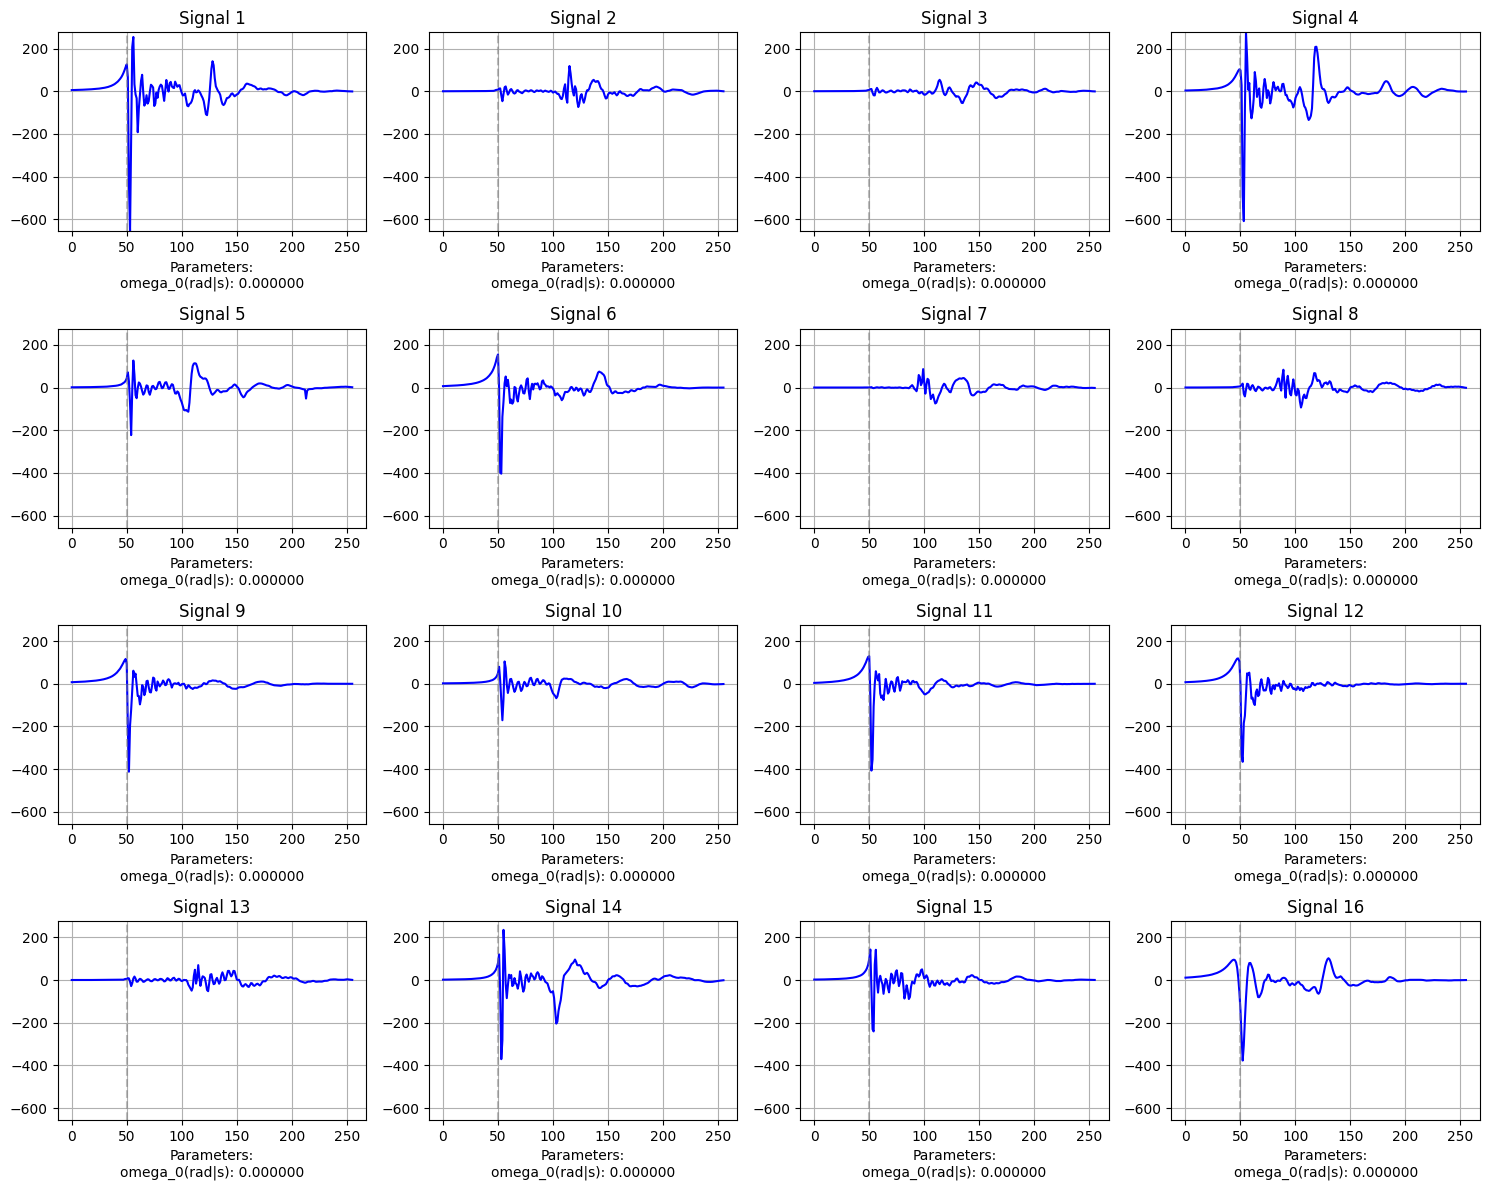

In [345]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

ylim_signal = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = [parameter]

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y, color='blue')

        ax.axvline(x=50, color='grey', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(ylim_signal)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(256, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

### Weight Initialisation

In [346]:
# custom weights initialization called on classifier
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Classifier Network

In [347]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2)
            )

            self.fc_class = nn.Sequential(
                nn.Linear(8192, num_classes),
                nn.LogSoftmax(dim=1)
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)
            x = self.fc_class(x)
            return x

In [348]:
net = Discriminator().to(device)
net.apply(weights_init)

print(net)

model = Discriminator()
summary(model, input_size=(1, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

### Loss functions and Optimisers

In [349]:
if (prediction_type == "regression"):
    criterion = nn.MSELoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

### Training

In [350]:
C_gradients = []
C_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        y = y.squeeze(1)

        # print(x)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_hat = net(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        # save losses and gradients for plotting later
        # C_gradients.append([param.grad.norm().item() for param in net.parameters()])
        C_losses.append(loss.item())
        running_loss += loss.item()

    print("Epoch: "f'{epoch + 1} loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

Epoch: 1 loss: 75.214
Epoch: 2 loss: 77.438
Epoch: 3 loss: 80.351
Epoch: 4 loss: 78.678
Epoch: 5 loss: 78.230
Epoch: 6 loss: 77.306
Epoch: 7 loss: 74.239
Epoch: 8 loss: 72.367
Epoch: 9 loss: 71.028
Epoch: 10 loss: 70.129
Epoch: 11 loss: 72.328
Epoch: 12 loss: 69.487
Epoch: 13 loss: 67.192
Epoch: 14 loss: 68.076
Epoch: 15 loss: 65.854
Epoch: 16 loss: 65.472
Epoch: 17 loss: 65.184
Epoch: 18 loss: 64.427
Epoch: 19 loss: 64.310
Epoch: 20 loss: 63.673
Epoch: 21 loss: 62.459
Epoch: 22 loss: 61.156
Epoch: 23 loss: 60.751
Epoch: 24 loss: 61.373
Epoch: 25 loss: 61.398
Epoch: 26 loss: 60.043
Epoch: 27 loss: 60.698
Epoch: 28 loss: 61.593
Epoch: 29 loss: 57.076
Epoch: 30 loss: 59.604
Epoch: 31 loss: 59.674
Epoch: 32 loss: 61.044
Epoch: 33 loss: 57.850
Epoch: 34 loss: 56.670
Epoch: 35 loss: 54.934
Epoch: 36 loss: 56.020
Epoch: 37 loss: 54.702
Epoch: 38 loss: 55.099
Epoch: 39 loss: 55.489
Epoch: 40 loss: 53.721
Epoch: 41 loss: 53.487
Epoch: 42 loss: 52.651
Epoch: 43 loss: 51.682
Epoch: 44 loss: 52.0

### Loss

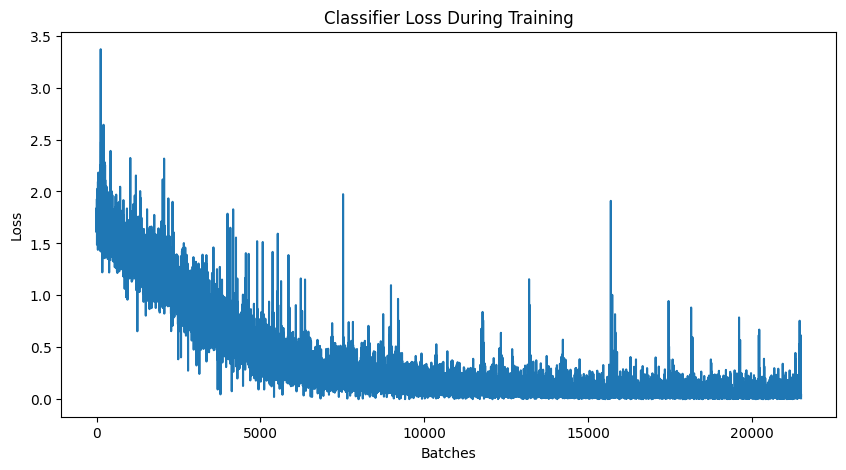

In [351]:
plt.figure(figsize=(10,5))
plt.title("Classifier Loss During Training")
plt.plot(C_losses,label="C")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.show()

### Testing

In [352]:
confusion_mtx = torch.zeros(num_classes, num_classes)

cum_true_indices = torch.Tensor().to(device, dtype=torch.float32)
cum_predicted_indices = torch.Tensor().to(device, dtype=torch.float32)

correct_classifications = 0
total_samples = 0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y = y.squeeze(1)
        y_hat = net(x)

        true_indices = torch.argmax(y, dim=1)
        predicted_indices = torch.argmax(y_hat, dim=1)

        correct_classifications += torch.sum(true_indices == predicted_indices).item()
        total_samples += true_indices.size(0)

        cum_true_indices = torch.cat([cum_true_indices, true_indices], dim=0)
        cum_predicted_indices = torch.cat([cum_predicted_indices, predicted_indices], dim=0)

cumulative_proportion_correct = correct_classifications / total_samples
print("Cumulative Proportion of Correct Classifications:", cumulative_proportion_correct)


Cumulative Proportion of Correct Classifications: 0.3086053412462908


### Confusion Matrix

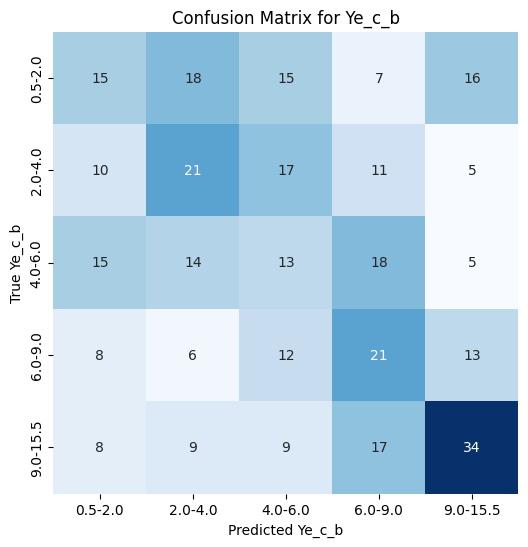

In [353]:
if parameter == 'beta1_IC_b':
    display_labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]
elif parameter == 'A(km)':
    display_labels = [300, 467, 634, 1268, 10000]
elif parameter == 'omega_0(rad|s)':
    display_labels = ['0.5-2.0', '2.0-4.0', '4.0-6.0', '6.0-9.0', '9.0-15.5']
elif parameter == 'Ye_c_b':
    display_labels = ['0.247-0.267', '0.267-0.288', '0.288-0.309', '0.309-0.330', '0.330-0.351']

confusion_matrix = metrics.confusion_matrix(cum_true_indices.cpu(), cum_predicted_indices.cpu())

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix.T, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels, cbar=False)

plt.title('Confusion Matrix for Ye_c_b')
plt.ylabel('True Ye_c_b')
plt.xlabel('Predicted Ye_c_b')
# plt.savefig('../plots/Ye_c_b_original_confusion_matrix.png')
plt.show()

In [354]:
# torch.save(net, "../models/omega_0_signals.pt")

Cumulative Proportion of correct classifications (beta_ic_b): 53.70919881305638%
Cumulative Proportion of correct classifications (A): 49.851632047477745%
Cumulative Proportion of correct classifications (omega_0): 34.718100890207715%
Cumulative Proportion of correct classifications (Ye): 71.81008902077152%